# GNOD 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Selecting features to cluster from main dataframe

In [2]:
data = pd.read_csv("spotify_data.csv")
data1 = pd.read_csv("spotify_data1.csv")
data2 = pd.read_csv('spotify_data2.csv')

In [3]:
X_spotify = pd.concat ([data, data1,data2], axis=0).reset_index(drop=True)
X_spotify = X_spotify.drop (['Unnamed: 0'], axis=1)
X_spotify

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.813,0.560,2,-5.904,0,0.0618,0.108000,0.000000,0.2680,0.287,118.033,286041,4
1,0.672,0.745,5,-5.269,0,0.3000,0.438000,0.000009,0.0699,0.739,173.974,413111,4
2,0.806,0.875,7,-3.817,1,0.0880,0.083800,0.001920,0.0650,0.917,125.063,224693,4
3,0.734,0.933,11,-4.639,0,0.0578,0.037500,0.000000,0.3020,0.935,120.987,218413,4
4,0.709,0.801,0,-4.688,1,0.0533,0.025200,0.000000,0.1590,0.829,128.007,189840,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5098,0.596,0.869,10,-11.970,1,0.0370,0.011600,0.173000,0.0678,0.944,109.902,238733,4
5099,0.492,0.683,1,-13.944,0,0.0342,0.195000,0.051500,0.1520,0.495,170.029,308800,4
5100,0.661,0.908,5,-4.897,1,0.0390,0.052000,0.000000,0.0708,0.656,144.091,296080,4
5101,0.554,0.963,6,-3.762,0,0.0350,0.000244,0.070200,0.4310,0.918,128.175,195147,4


In [4]:
X_prep = StandardScaler().fit_transform(X_spotify)

# Now, all features will have the same weight.
pd.DataFrame(X_prep,columns=X_spotify.columns).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.571999,-0.185915,-0.881512,0.896431,-1.578865,0.137485,-0.723387,-0.302365,0.441359,-1.146931,-0.074714,0.474134,0.229403
1,0.696841,0.683491,-0.038860,1.068448,-1.578865,4.879878,0.448595,-0.302306,-0.732408,0.655771,1.939680,1.846261,0.229403
2,1.528552,1.294424,0.522907,1.461786,0.633367,0.659109,-0.809332,-0.290157,-0.761441,1.365685,0.178431,-0.188314,0.229403
3,1.081662,1.566995,1.646443,1.239111,-1.578865,0.057848,-0.973765,-0.302365,0.642813,1.437474,0.031658,-0.256126,0.229403
4,0.926493,0.946662,-1.443279,1.225837,0.633367,-0.031744,-1.017448,-0.302365,-0.204479,1.014717,0.284443,-0.564663,0.229403


# Choosing k

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

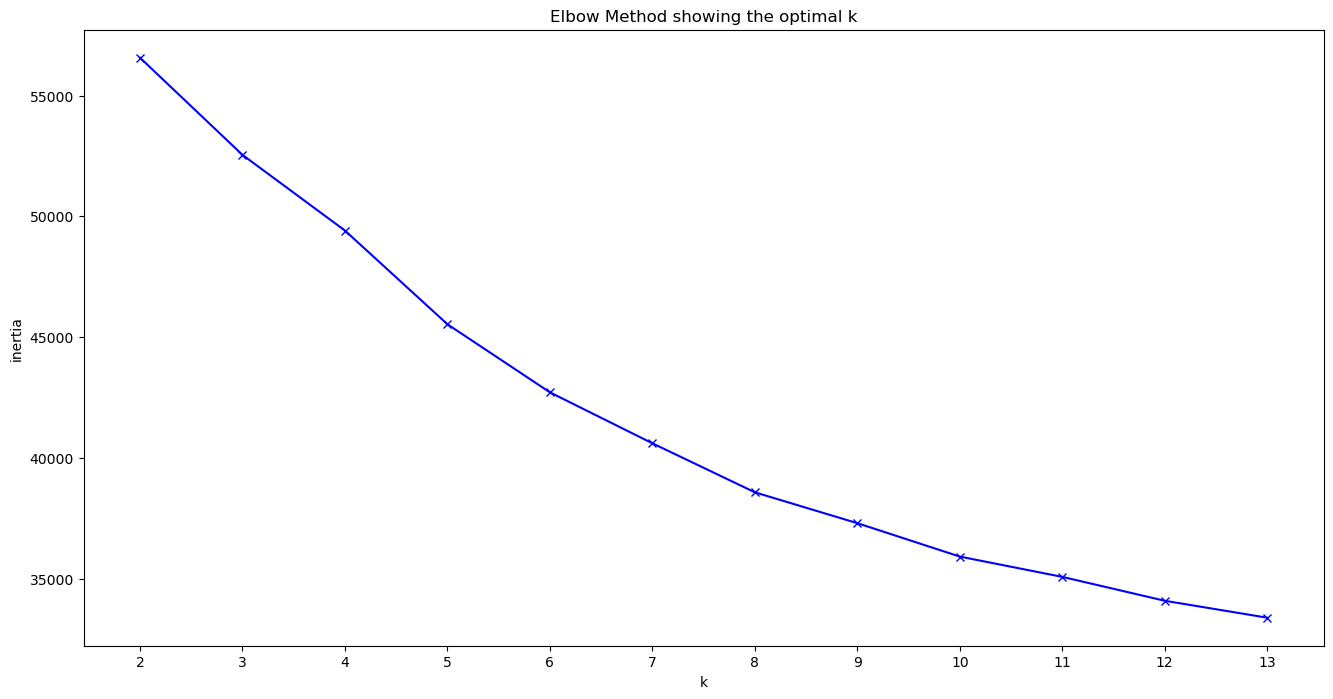

In [12]:
# We have 13 features so the range must be 2-14
K = range(2, 14)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

- Difficult to see the elbow, but could be 6

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

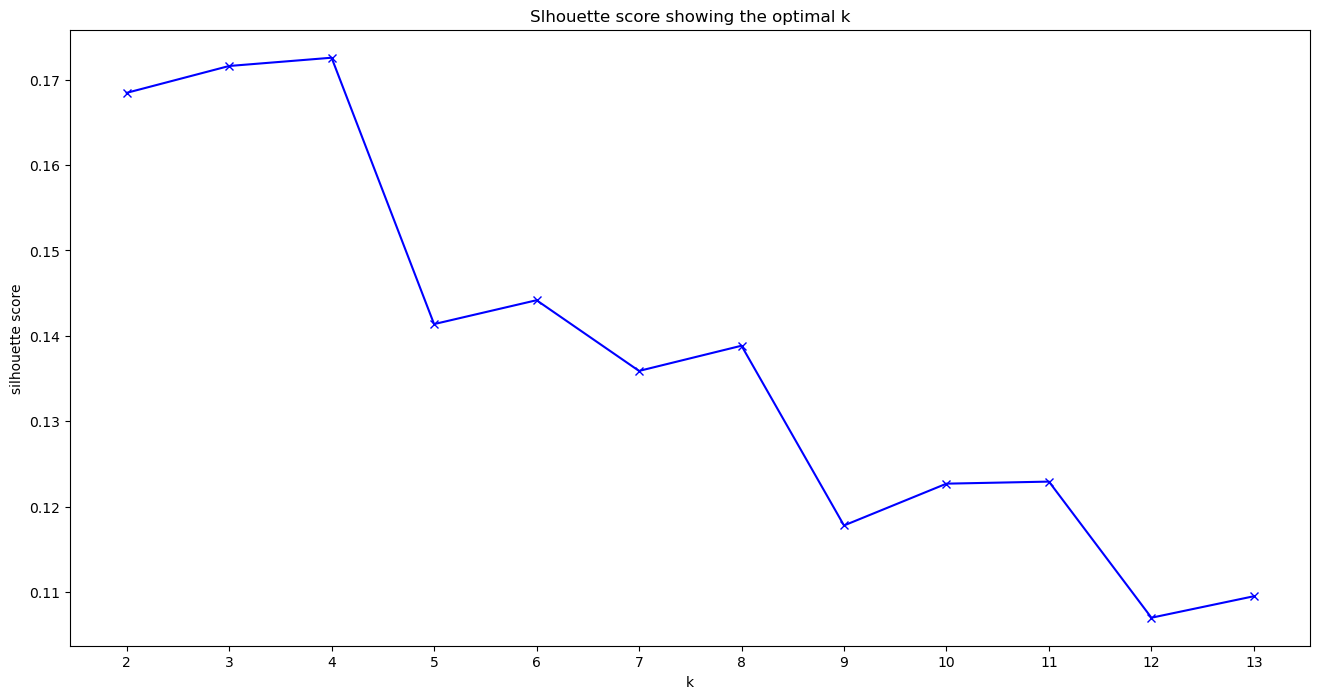

In [13]:
K = range(2, 14)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

- It is reaffirmed that 6 would be optimal, but we see 4 with the highest value, so in this case it would be the optimal choice.

## Checking KMeans with 4 and 6 clusters

#### Number of clusters = 4

In [14]:
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=4, random_state=1234)

In [15]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0     271
1    2981
2    1588
3     263
dtype: int64

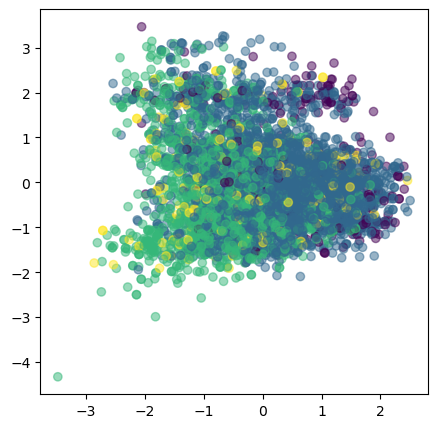

In [29]:
# Plotting (num clusters = 4)
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 10], c=clusters,alpha=0.5)

plt.show()